# Week 8 Lab: Decision Trees and Random Forests

Last week we discussed regression and how it can be used to predict continuous valued labels. This time we will look at the discrete valued label case which is broadly known as classification. In particular, we will look at two well-known algorithms: decision trees and random forests. Recall, both regression and classification are known as supervised learning tasks as we actually know what the labels are beforehand. This contrasts with unsupervised learning (clustering) in which we do not know the labels and are instead trying to find these labels as opposed to predicting them.

As ever, to run each cell use SHIFT + ENTER.

## 8.1 Decision Trees

We will explore the use of decision trees by working with the _KyphisisDisease.csv_ dataset. Kyphosis is a type of spinal deformation and dataset concerns patients who have had corrective surgery. We note there are four columns in the dataset: Age, Number, Start and Kyphosis. The _Age_ is measured in months, _Number_ refers to the number of vertebrae involved in the surgery, and _Start_ refers to the top-most vertebrae that was operated on. Finally, _Kyphosis_ relates to whether or not the patient still had kyphisis _after_ the surgery: 0 means they did, 1 means they did not.

## 8.1.1 Data Exploration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv('KyphosisDisease.csv')
df.head(11)    # Print out first 10 patients to see the first patient with Kyphosis

,age,number,start,Kyphosis
0,80,4,7,0
1,36,7,8,0
2,191,5,4,0
3,24,8,15,0
4,177,5,2,0
5,124,6,5,0
6,38,6,17,0
7,40,2,10,0
8,89,6,15,0
9,116,6,6,0


In [3]:
df.describe()

,age,number,start,Kyphosis
count,41188.000000,41188.000000,41188.000000,41188.000000
mean,101.518865,5.620132,9.252355,0.112654
std,58.075841,2.321693,5.107928,0.316173
min,1.000000,2.000000,1.000000,0.000000
25%,51.000000,4.000000,5.000000,0.000000
50%,100.000000,6.000000,9.000000,0.000000
75%,150.000000,8.000000,14.000000,0.000000
max,206.000000,10.000000,18.000000,1.000000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   age       41188 non-null  int64
 1   number    41188 non-null  int64
 2   start     41188 non-null  int64
 3   Kyphosis  41188 non-null  int64
dtypes: int64(4)
memory usage: 1.3 MB


C:\Users\jdpev\anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


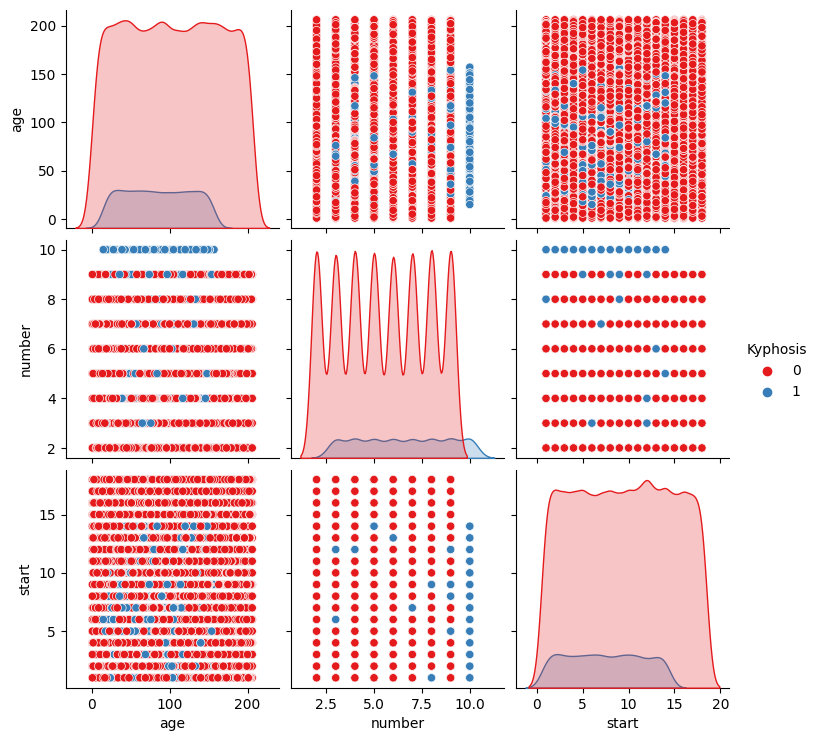

In [5]:
sns.pairplot(df,hue='Kyphosis',palette='Set1')

One thing that does seem clear is that the absence of kyphosis seems to be much more common. Given the subject matter, it might be worth exploring this further.

In [6]:
df['Kyphosis'].value_counts()

0    36548
1     4640
Name: Kyphosis, dtype: int64

<Axes: xlabel='Kyphosis', ylabel='count'>

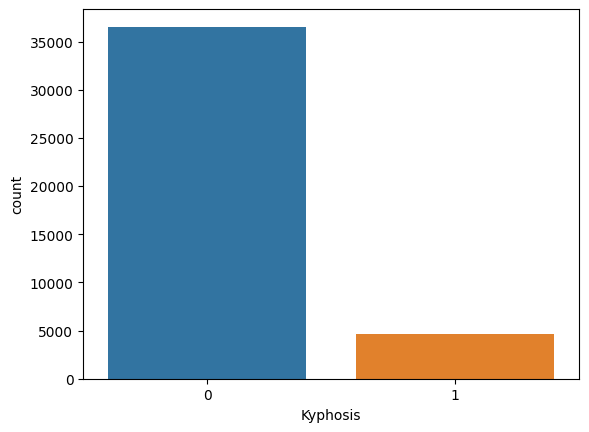

In [7]:
sns.countplot(x='Kyphosis', data=df)

In [8]:
count_no_kyp = len(df[df['Kyphosis']==0])
count_kyp = len(df[df['Kyphosis']==1])

pct_no_kyp = count_no_kyp / (count_no_kyp + count_kyp)
pct_kyp = count_kyp / (count_no_kyp + count_kyp)

print('Percentage of no kyphosis:', pct_no_kyp * 100)
print('Percentage of kyphosis:', pct_kyp * 100)

Percentage of no kyphosis: 88.73458288821988
Percentage of kyphosis: 11.265417111780131


We see that the classes are imbalanced (ratio of 89:11). Let's explore further.

In [9]:
df.groupby('Kyphosis').mean()

,age,number,start
Kyphosis,,,
0,103.588350,5.505062,9.482270
1,85.218103,6.526509,7.441379


This tells us that the average age of patients who still had kyphosis after surgery is lower than patients who did not have kyphosis. We also note that the average number of vertebrae involved is higher with those who had kyphosis (so, higher the number, the greater chance of having kyphosis) and the number is lower (i.e. surgery starts higher up the spine).

## 8.1.2 Create the Model

First we split the data into a training set and a test set.

In [10]:
from sklearn.model_selection import train_test_split

X = df.drop('Kyphosis',axis=1)
y = df['Kyphosis']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

Now we train a single decision tree.

In [11]:
from sklearn.tree import DecisionTreeClassifier

dtree = DecisionTreeClassifier()
dtree.fit(X_train,y_train)

DecisionTreeClassifier()

Next we evaluate our decision tree.

In [12]:
predictions = dtree.predict(X_test)

In [13]:
from sklearn.metrics import classification_report,confusion_matrix

print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.91      0.93      0.92     10992
           1       0.31      0.26      0.28      1365

    accuracy                           0.86     12357
   macro avg       0.61      0.59      0.60     12357
weighted avg       0.84      0.86      0.85     12357



In [14]:
print(confusion_matrix(y_test,predictions))

[[10231   761]
 [ 1016   349]]


This is telling us that we have $10318 + 332$ correct predictions and $1030 + 677$ incorrect predictions.

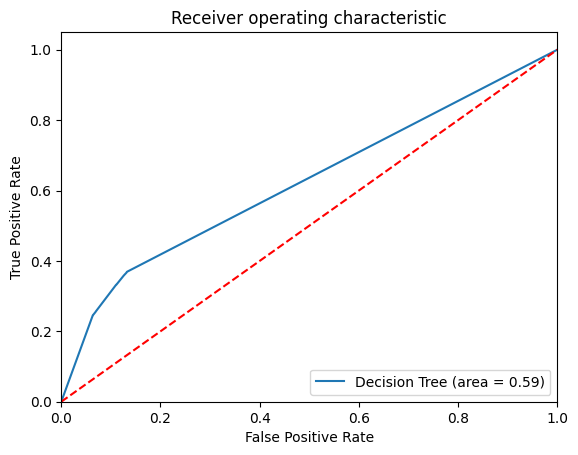

In [15]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

dtree_roc_auc = roc_auc_score(y_test, dtree.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, dtree.predict_proba(X_test)[:,1])

plt.figure()
plt.plot(fpr, tpr, label='Decision Tree (area = %0.2f)' % dtree_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc='lower right')

The receiver operating characteristic (ROC) curve is another common tool used with binary classifiers. The dotted line represents the ROC curve of a purely random classifier; a good classifier stays as far away from that line as possible (toward the top-left corner).

## 8.1.3 Visualise the Model

For this, we will need to install the pydot and graphviz libraries. We won't often need to do this since visualisation is not often necessary for these kinds of tasks. As you can see, given the size of our dataset, the visualisation is pretty unreadable. Nevertheless, it is worth discussing and on Canvas there is another Kyphosis dataset which is smaller (_kyphosis.csv_). As an exercise, try repeating this for that smaller dataset and a much more readable decision tree will be produced.

In [16]:
from IPython.display import Image  
from six import StringIO  
from sklearn.tree import export_graphviz
import pydot 

features = list(df.columns[:3])
features

['age', 'number', 'start']

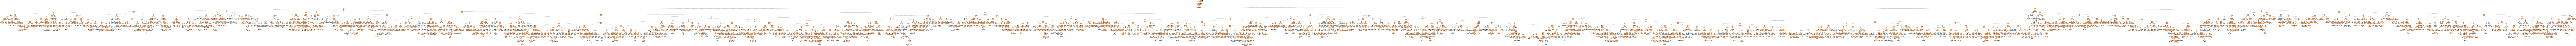

In [17]:
dot_data = StringIO()  
export_graphviz(dtree, out_file=dot_data,feature_names=features,filled=True,rounded=True)

graph = pydot.graph_from_dot_data(dot_data.getvalue())  
Image(graph[0].create_png())  

## 8.2 Random Forests

For this section, the goal is to compare the decision tree model above with a random forest model.

In [18]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=200)    # Play about with this estimator
rfc.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200)

In [19]:
rfc_pred = rfc.predict(X_test)

In [20]:
print(classification_report(y_test,rfc_pred))

              precision    recall  f1-score   support

           0       0.91      0.93      0.92     10992
           1       0.32      0.26      0.29      1365

    accuracy                           0.86     12357
   macro avg       0.62      0.59      0.60     12357
weighted avg       0.85      0.86      0.85     12357



In [21]:
print(confusion_matrix(y_test,rfc_pred))

[[10267   725]
 [ 1016   349]]


There doesn't seem to be much of a difference. Why might that be?

__Exercise:__ Repeat the above for the smaller _kyphosis.csv_ dataset. Is there a difference?

## 8.3 Balancing the Data

Let's go back to the decision tree from Section 8.1. Recall, we mentioned the data is imbalanced. Let's see what happens if we address this. We will up-sample the kyphosis using the SMOTE algorithm (Synthetic Minority Oversampling Technique). At a high level, SMOTE:

1. Works by creating synthetic samples from the minor class (kyphosis) instead of creating copies.
2. Randomly choosing one of the k-nearest-neighbors and using it to create a similar, but randomly tweaked, new observations.

In [22]:
data_final = df.copy()
data_final.columns.values

array(['age', 'number', 'start', 'Kyphosis'], dtype=object)

In [23]:
X = data_final.loc[:, data_final.columns != 'Kyphosis']
y = data_final.loc[:, data_final.columns == 'Kyphosis']

In [24]:
from imblearn.over_sampling import SMOTE

os = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns = X_train.columns

os_data_X,os_data_y=os.fit_resample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['Kyphosis'])

# we can Check the numbers of our data
print('length of oversampled data is ',len(os_data_X))
print('Number of no kyphosis in oversampled data', len(os_data_y[os_data_y['Kyphosis']==0]))
print('Number of kyphosis', len(os_data_y[os_data_y['Kyphosis']==1]))
print('Proportion of no kyphosis data in oversampled data is ', len(os_data_y[os_data_y['Kyphosis']==0]) / len(os_data_X))
print('Proportion of kyphosis data in oversampled data is ', len(os_data_y[os_data_y['Kyphosis']==1]) / len(os_data_X))

length of oversampled data is  51106
Number of no kyphosis in oversampled data 25553
Number of kyphosis 25553
Proportion of no kyphosis data in oversampled data is  0.5
Proportion of kyphosis data in oversampled data is  0.5


We now have balanced data.

__N.B.__ We oversampled only on the training data. This is because, by oversampling only on the training data, none of the information in the test data is being used to create synthetic observations. Thus, no information will bleed from test data into the model training.

At this point, we could perform recursive feature elimination (RFE) which repeatedly constructs a model, chooses either the best or worse performing feature, removes this feature and then repeats the process with the other features. In doing so, we select the most relevant features with the idea being that fewer features is preferable since it allows machine learning algorithms to run more efficiently (less space/time complexity). For RFE there are two important configuration options: the choice in the number of features to select, and the choice of the algorithm used to help choose features.

For our dataset, we would expect to need all three features. As such, we will not dwell on this much. It is enough to be aware of its existence and see it in practice

In [25]:
from sklearn.feature_selection import RFE

data_final_vars=data_final.columns.values.tolist()

y=['Kyphosis']
X=[i for i in data_final_vars if i not in y]

dtree = DecisionTreeClassifier()
rfe = RFE(dtree, n_features_to_select=3)
rfe = rfe.fit(os_data_X, os_data_y.values.ravel())

print(rfe.support_)
print(rfe.ranking_)

[ True  True  True]
[1 1 1]


As expected, the RFE has selected all three features.

In [26]:
cols=['age', 'number', 'start'] 
X=os_data_X[cols]
y=os_data_y['Kyphosis']

dtree = DecisionTreeClassifier()

In [27]:
dtree_model=dtree.fit(X,y)

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

dtree = DecisionTreeClassifier()
dtree.fit(X_train, y_train)

DecisionTreeClassifier()

In [29]:
y_pred = dtree.predict(X_test)

print('Accuracy of decision tree classifier on test set: {:.2f}'.format(dtree.score(X_test, y_test)))

Accuracy of decision tree classifier on test set: 0.84


In [30]:
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[6214 1422]
 [ 960 6736]]


In [31]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.81      0.84      7636
           1       0.83      0.88      0.85      7696

    accuracy                           0.84     15332
   macro avg       0.85      0.84      0.84     15332
weighted avg       0.85      0.84      0.84     15332



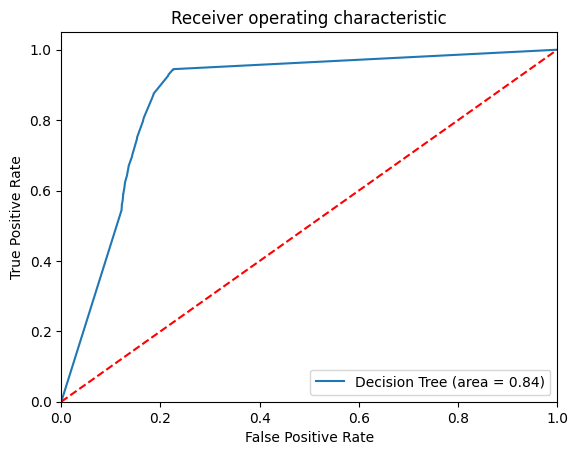

In [32]:
dtree_roc_auc = roc_auc_score(y_test, dtree.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, dtree.predict_proba(X_test)[:,1])

plt.figure()
plt.plot(fpr, tpr, label='Decision Tree (area = %0.2f)' % dtree_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc='lower right')

## 8.4 Exercise Problem

You are tasked with exploring publicly available data from [LendingClub.com](www.lendingclub.com). Lending Club connects people who need money (borrowers) with people who have money (investors). As an investor you would want to invest in people who showed a profile of having a high probability of paying you back. You are etherefore tasked with creating a model that will help predict this.

Lending club had a [very interesting year in 2016](https://en.wikipedia.org/wiki/Lending_Club#2016), so check out some of their data and keep the context in mind. This data is from before they even went public.

You will be using lending data from 2007-2010 and will try to classify and predict whether or not the borrower paid back their loan in full. You can download the data from [here](https://www.kaggle.com/datasets/wordsforthewise/lending-club) or just use the csv already provided. It's recommended you use the csv provided as it has been cleaned of NA values.

Here are what the columns represent:
* credit.policy: 1 if the customer meets the credit underwriting criteria of LendingClub.com, and 0 otherwise.
* purpose: The purpose of the loan (takes values "credit_card", "debt_consolidation", "educational", "major_purchase", "small_business", and "all_other").
* int.rate: The interest rate of the loan, as a proportion (a rate of 11% would be stored as 0.11). Borrowers judged by LendingClub.com to be more risky are assigned higher interest rates.
* installment: The monthly installments owed by the borrower if the loan is funded.
* log.annual.inc: The natural log of the self-reported annual income of the borrower.
* dti: The debt-to-income ratio of the borrower (amount of debt divided by annual income).
* fico: The FICO credit score of the borrower.
* days.with.cr.line: The number of days the borrower has had a credit line.
* revol.bal: The borrower's revolving balance (amount unpaid at the end of the credit card billing cycle).
* revol.util: The borrower's revolving line utilization rate (the amount of the credit line used relative to total credit available).
* inq.last.6mths: The borrower's number of inquiries by creditors in the last 6 months.
* delinq.2yrs: The number of times the borrower had been 30+ days past due on a payment in the past 2 years.
* pub.rec: The borrower's number of derogatory public records (bankruptcy filings, tax liens, or judgments).

Perform the following tasks:

1. Load the data and explore the basic information.
2. Create a histogram of two FICO distributions on top of each other, one for each credit.policy outcome.
3. Create a similar figure as in part (2) but this time select by the not.fully.paid column.
4. Create a countplot using seaborn showing the counts of loans by purpose with the colour hue defined by not.fully.paid.
5. Create a jointplot to see the trend between FICO score and interest rate.
6. Create two lmplots to see if the trend differed between not.fully.paid and credit.policy.
7. Observe that the purpose column is categorical. This means you need to transform them using dummy variables so that sklearn will be able to understand them. Do this using `pd.get_dummies`.
8. Split your data into a training set and a test set.
9. Train your decision tree model.
10. Make predictions using your model and evaluate your decision tree.
11. Now train your random forest model.
12. Make predictions using your model and evaluate your random forest.
13. Decide which model worked better.

## 8.5 Summary

We should now be able to construct decision trees and random forests and evaluate their effectiveness.

References:

https://medium.com/@polanitzer/developing-a-decision-tree-algorithm-in-python-for-predicting-a-kyphosis-after-a-corrective-spinal-50169542d666